In [118]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
import torch
import numpy as np
np.random.seed(42)

In [119]:
from google.colab import drive
drive.mount('/content/drive')

# Cargar datos
features = pd.read_parquet("/content/drive/MyDrive/Archivos_ALeRCE/features_cleaned.parquet", engine="pyarrow")
cross = pd.read_csv("/content/drive/MyDrive/Archivos_ALeRCE/dfcrossmatches_prioritized_v7.0.1.csv")
detecciones = pd.read_csv("/content/drive/MyDrive/Archivos_ALeRCE/detections_SNe_v7.0.1.csv")

# Unir por 'oid' y quedarnos con la clase
df_merged = features.merge(
    cross[['oid', 'classALeRCE']],
    on='oid', how='left'
)

# Filtrar sólo supernovas (SN*) y SLSN
mask_sn = df_merged['classALeRCE'].str.startswith('SN', na=False) | (df_merged['classALeRCE']=='SLSN')
df_sn = df_merged[mask_sn].copy()

# Mapear a 4 clases (SNIa, SNIbc, SNII, SLSN)
def map_sn(cls):
    if pd.isna(cls): return np.nan
    if cls == 'SLSN': return 'SLSN'
    if cls.startswith('SNIa'): return 'SNIa'
    if cls.startswith('SNIbc'): return 'SNIbc'
    if cls.startswith('SNII'): return 'SNII'
    return np.nan

df_sn['class4'] = df_sn['classALeRCE'].apply(map_sn)
df_sn = df_sn[df_sn['class4'].isin(['SNIa','SNIbc','SNII','SLSN'])].copy()

# Separar X, y
feature_cols = [c for c in df_sn.columns if c not in ['oid','classALeRCE','class4']]
X = df_sn[feature_cols].values.astype('float32')
y = df_sn['class4'].values

# Codificación de etiquetas
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_int = le.fit_transform(y)
num_classes = len(le.classes_)
print('Clases:', list(le.classes_))
print(f'Distribución: {np.bincount(y_int)}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Clases: ['SLSN', 'SNII', 'SNIa', 'SNIbc']
Distribución: [  24  339 1364   96]


In [120]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_int, y_test_int = train_test_split(
    X, y_int, test_size=0.20, random_state=42, stratify=y_int
)

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")


Train: (1458, 178), Test: (365, 178)


In [174]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

prep = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value=0.0)),
    ('sc', StandardScaler())
])

X_train_p = prep.fit_transform(X_train)
X_test_p = prep.transform(X_test)

In [175]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)

def build_mlp(input_dim, num_classes, dropout=0.5):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu')(inp)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation='relu', name='latent_layer')(x)  # Nombrada para fácil acceso
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_mlp(X_train_p.shape[1], num_classes)
model.summary()

# Pesos de clase
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights = {i:w for i,w in enumerate(class_weights)}
print(f"\nPesos de clase: {class_weights}")

# Callbacks
cb = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]

# Entrenar
history = model.fit(
    X_train_p, y_train_int,
    epochs=200,
    batch_size=256,
    validation_split=0.2,
    callbacks=cb,
    class_weight=class_weights,
    verbose=2
)

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 178)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │        45,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_layer (Dense)            │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,236 (309.52 KB)

 Trainable params: 79,236 (309.52 KB)

 Non-trainable params: 0 (0.00 B)


Pesos de clase: {0: np.float64(19.18421052631579), 1: np.float64(1.345018450184502), 2: np.float64(0.3340971585701192), 3: np.float64(4.733766233766234)}
Epoch 1/200
5/5 - 2s - 310ms/step - accuracy: 0.3328 - loss: 1.9435 - val_accuracy: 0.4897 - val_loss: 1.1592 - learning_rate: 1.0000e-03
Epoch 2/200
5/5 - 0s - 28ms/step - accuracy: 0.3705 - loss: 1.6053 - val_accuracy: 0.4178 - val_loss: 1.2037 - learning_rate: 1.0000e-03
Epoch 3/200
5/5 - 0s - 28ms/step - accuracy: 0.3139 - loss: 1.5967 - val_accuracy: 0.4932 - val_loss: 1.1577 - learning_rate: 1.0000e-03
Epoch 4/200
5/5 - 0s - 59ms/step - accuracy: 0.4048 - loss: 1.2088 - val_accuracy: 0.5719 - val_loss: 1.1068 - learning_rate: 1.0000e-03
Epoch 5/200
5/5 - 0s - 27ms/step - accuracy: 0.4537 - loss: 1.1758 - val_accuracy: 0.5959 - val_loss: 1.0726 - learning_rate: 1.0000e-03
Epoch 6/200
5/5 - 0s - 31ms/step - accuracy: 0.4477 - loss: 1.1670 - val_accuracy: 0.6199 - val_loss: 1.0421 - learning_rate: 1.0000e-03
Epoch 7/200
5/5 - 0s -

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

        SLSN       0.60      0.60      0.60         5
        SNII       0.63      0.76      0.69        68
        SNIa       0.92      0.79      0.85       273
       SNIbc       0.12      0.26      0.17        19

    accuracy                           0.76       365
   macro avg       0.57      0.61      0.58       365
weighted avg       0.82      0.76      0.78       365



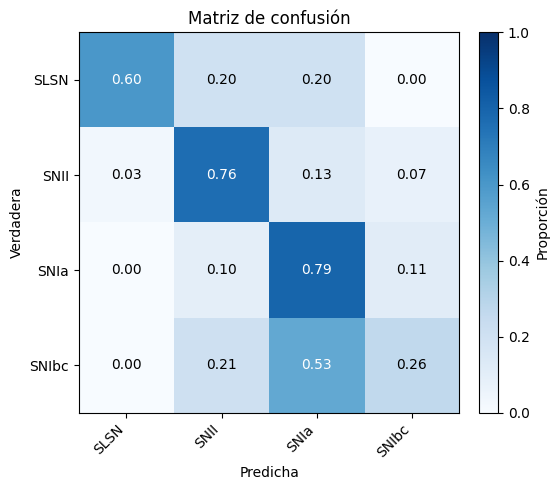

In [176]:
from sklearn.metrics import classification_report, confusion_matrix

y_proba = model.predict(X_test_p)
y_pred = np.argmax(y_proba, axis=1)

print("\n" + "="*70)
print("REPORTE DE CLASIFICACIÓN")
print("="*70)
print(classification_report(y_test_int, y_pred, target_names=le.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test_int, y_pred, labels=np.arange(len(le.classes_)))
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_pct = np.nan_to_num(cm_pct)

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_pct, cmap='Blues', vmin=0, vmax=1)

ax.set_xticks(np.arange(len(le.classes_)))
ax.set_yticks(np.arange(len(le.classes_)))
ax.set_xticklabels(le.classes_, rotation=45, ha='right')
ax.set_yticklabels(le.classes_)
ax.set_xlabel('Predicha')
ax.set_ylabel('Verdadera')
ax.set_title('Matriz de confusión')

for i in range(cm_pct.shape[0]):
    for j in range(cm_pct.shape[1]):
        ax.text(j, i, f'{cm_pct[i, j]:.2f}', ha='center', va='center',
                color='black' if cm_pct[i, j] < 0.5 else 'white')

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Proporción')
plt.tight_layout()
plt.show()


In [177]:
print("\n" + "="*70)
print("EXTRACCIÓN DE FEATURES LATENTES")
print("="*70)

# Método más robusto: usar la penúltima capa
encoder_model = keras.Model(
    inputs=model.input,
    outputs=model.get_layer('latent_layer').output  # Usando el nombre de la capa
)

# Extraer features para TRAIN y TEST
X_train_latent = encoder_model.predict(X_train_p, batch_size=256, verbose=0)
X_test_latent = encoder_model.predict(X_test_p, batch_size=256, verbose=0)

print(f"Features latentes Train: {X_train_latent.shape}")
print(f"Features latentes Test: {X_test_latent.shape}")


EXTRACCIÓN DE FEATURES LATENTES
Features latentes Train: (1458, 128)
Features latentes Test: (365, 128)


In [178]:
import time
import umap
from sklearn.manifold import TSNE

class_names_sn = list(le.classes_)

print("\n" + "="*70)
print("REDUCCIÓN DE DIMENSIONALIDAD")
print("="*70)

# UMAP ANTES DE LA MLP (en datos originales)
print("\n--- UMAP Antes de MLP ---")
time_start = time.time()
reducer_umap_before = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)
# MEJORA: Entrenar en train, transformar ambos
Z_train_2D_umap_before = reducer_umap_before.fit_transform(X_train_p)
Z_test_2D_umap_before = reducer_umap_before.transform(X_test_p)
print(f"UMAP (Antes) completado en: {time.time() - time_start:.2f} segundos")
print(f"Train: {Z_train_2D_umap_before.shape}, Test: {Z_test_2D_umap_before.shape}")

# UMAP DESPUÉS DE LA MLP (en features latentes)
print("\n--- UMAP Después de MLP ---")
time_start = time.time()
reducer_umap = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)
# MEJORA: Entrenar en train, transformar ambos
Z_train_2D_umap = reducer_umap.fit_transform(X_train_latent)
Z_test_2D_umap = reducer_umap.transform(X_test_latent)
print(f"UMAP (Después) completado en: {time.time() - time_start:.2f} segundos")
print(f"Train: {Z_train_2D_umap.shape}, Test: {Z_test_2D_umap.shape}")

# t-SNE (solo en test para visualización rápida)
print("\n--- t-SNE Después de MLP ---")
time_start = time.time()
reducer_tsne = TSNE(n_components=2, verbose=0, random_state=42, n_jobs=-1)
Z_test_2D_tsne = reducer_tsne.fit_transform(X_test_latent)
print(f"t-SNE completado en: {time.time() - time_start:.2f} segundos")
print(f"Test: {Z_test_2D_tsne.shape}")


REDUCCIÓN DE DIMENSIONALIDAD

--- UMAP Antes de MLP ---


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP (Antes) completado en: 8.63 segundos
Train: (1458, 2), Test: (365, 2)

--- UMAP Después de MLP ---


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP (Después) completado en: 8.57 segundos
Train: (1458, 2), Test: (365, 2)

--- t-SNE Después de MLP ---
t-SNE completado en: 3.35 segundos
Test: (365, 2)


In [179]:
# Colores personalizados para las 4 clases
custom_colors = {
    'SLSN': 'red',
    'SNIa': 'lightskyblue',
    'SNIbc': 'mediumvioletred',
    'SNII': 'navy'
}

def plot_latent_space(Z_2D, y_labels_int, title, class_names, custom_colors=None, figsize=(8, 8)):
    """Grafica el espacio latente 2D coloreado por clases."""
    fig, ax = plt.subplots(figsize=figsize)

    for i, class_name in enumerate(class_names):
        mask = (y_labels_int == i)

        if custom_colors and class_name in custom_colors:
            color = custom_colors[class_name]
        else:
            cmap = plt.cm.get_cmap('Spectral', len(class_names))
            color = cmap(i)

        ax.scatter(
            Z_2D[mask, 0],
            Z_2D[mask, 1],
            label=class_name,
            color=color,
            alpha=0.7,
            s=15
        )

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(title='Clases', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')
    plt.tight_layout()
    plt.show()


def plot_umap_by_pred(Z, y_pred, class_names, custom_colors=None):
    """Grafica UMAP coloreado por predicción MSVDD."""
    plt.figure(figsize=(8, 7))

    for i, name in enumerate(class_names):
        mask = (y_pred == i)

        if custom_colors and name in custom_colors:
            color = custom_colors[name]
        else:
            cmap = plt.cm.get_cmap("Spectral", len(class_names))
            color = cmap(i)

        plt.scatter(
            Z[mask, 0], Z[mask, 1],
            s=20, alpha=0.8,
            color=color,
            label=f"{name}"
        )

    plt.title("UMAP – Clusters DESPUÉS del Multiclass (Predicción MSVDD)",
              fontsize=12, fontweight='bold')
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title="Predicción MSVDD", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_umap_anomalies(Z, anomaly_score, color_normal='deepskyblue', color_anomaly='blue'):
    """Grafica UMAP con anomalías destacadas."""
    plt.figure(figsize=(8, 7))

    normal = anomaly_score >= 0
    anomalous = anomaly_score < 0

    plt.scatter(
        Z[normal, 0], Z[normal, 1],
        s=20, alpha=0.5, color=color_normal,
        label="Normales"
    )
    plt.scatter(
        Z[anomalous, 0], Z[anomalous, 1],
        s=80, alpha=1.0, color=color_anomaly, marker="X",
        label="Anomalías MSVDD"
    )

    plt.title("UMAP – Anomalías detectadas por Multiclass SVDD",
              fontsize=12, fontweight='bold')
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend()
    plt.tight_layout()
    plt.show()


VISUALIZACIONES


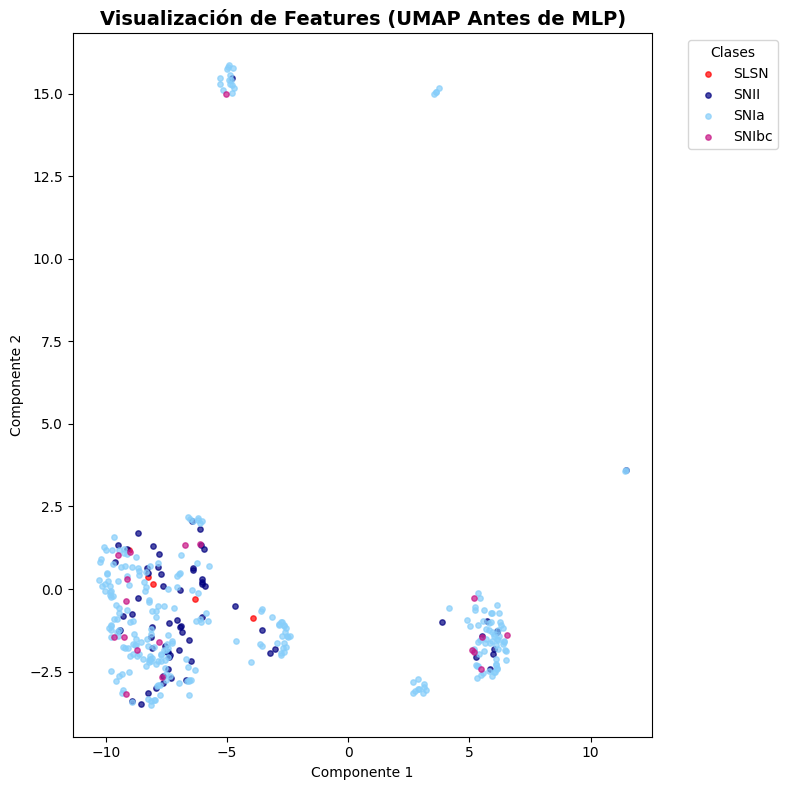

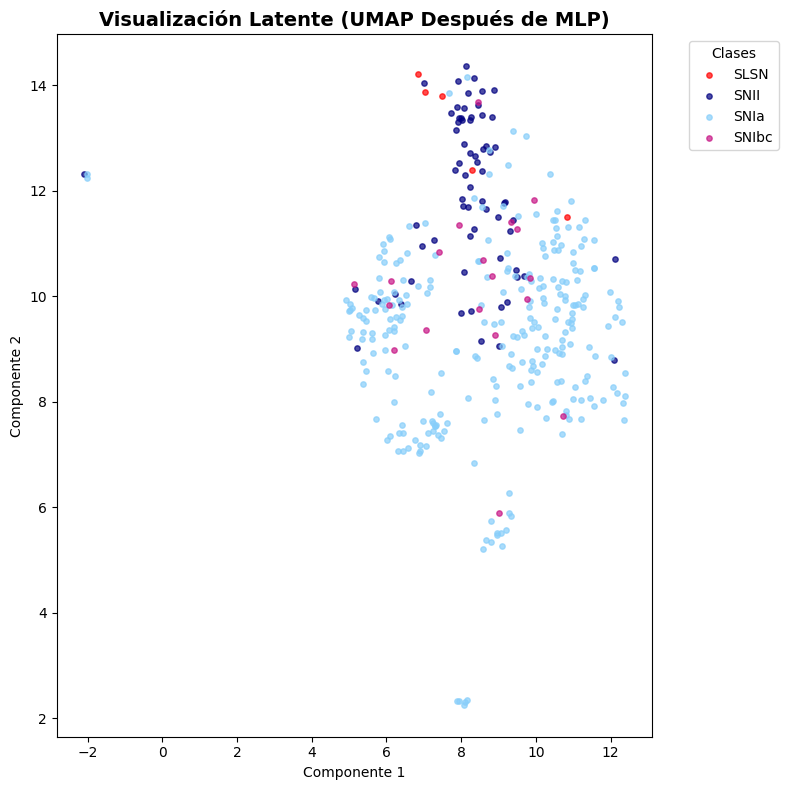

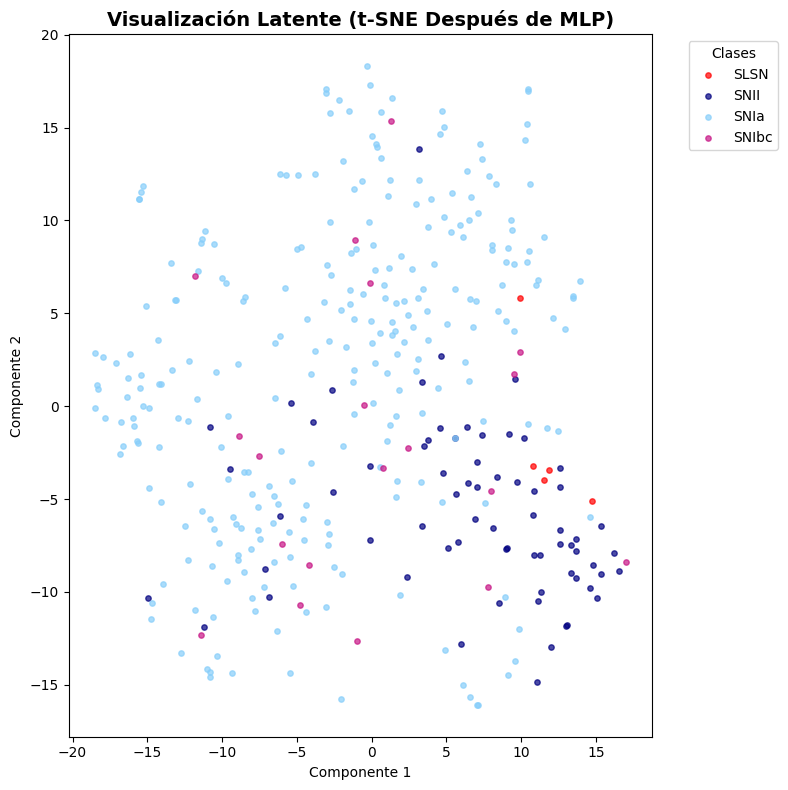

In [180]:
print("\n" + "="*70)
print("VISUALIZACIONES")
print("="*70)

# 1. ANTES DE LA MLP (solo test para comparación con original)
plot_latent_space(
    Z_test_2D_umap_before,
    y_test_int,
    'Visualización de Features (UMAP Antes de MLP)',
    class_names_sn,
    custom_colors=custom_colors
)

# 2. DESPUÉS DE LA MLP - UMAP
plot_latent_space(
    Z_test_2D_umap,
    y_test_int,
    'Visualización Latente (UMAP Después de MLP)',
    class_names_sn,
    custom_colors=custom_colors
)

# 3. DESPUÉS DE LA MLP - t-SNE
plot_latent_space(
    Z_test_2D_tsne,
    y_test_int,
    'Visualización Latente (t-SNE Después de MLP)',
    class_names_sn,
    custom_colors=custom_colors
)

In [181]:
from sklearn.svm import OneClassSVM

print("\n" + "="*70)
print("ENTRENAMIENTO DE MODELOS ONE-CLASS SVM (MSVDD)")
print("="*70)

ocsvm_models = {}
NU_PARAM = 0.1

# MEJORA: Entrenar en TRAIN, no en TEST
for class_id in range(num_classes):
    # Aislar muestras de train de esta clase
    X_class_train = X_train_latent[y_train_int == class_id]

    if len(X_class_train) == 0:
        print(f"Advertencia: No hay muestras para la clase {class_id}")
        continue

    ocsvm = OneClassSVM(
        kernel='rbf',
        nu=NU_PARAM,
        gamma='auto'
    )
    ocsvm.fit(X_class_train)
    ocsvm_models[class_id] = ocsvm

    class_name = le.classes_[class_id]
    print(f"OCSVM entrenado para {class_name} (N_train={len(X_class_train)})")

# Evaluar en TEST
decision_scores = np.zeros((X_test_latent.shape[0], num_classes))

for class_id, ocsvm in ocsvm_models.items():
    decision_scores[:, class_id] = ocsvm.decision_function(X_test_latent)

# Clasificación MSVDD
Z_pred_msvdd = np.argmax(decision_scores, axis=1)
anomaly_score = np.max(decision_scores, axis=1)

MSVDD_THRESHOLD = 0.0
anomalias_msvdd_indices = np.where(anomaly_score < MSVDD_THRESHOLD)[0]

print("\n" + "="*70)
print("RESULTADOS DEL CLASIFICADOR MSVDD")
print("="*70)

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_int, Z_pred_msvdd)
print(f"Clasificación MSVDD (Accuracy): {accuracy:.4f}")
print(f"\nReporte de Clasificación (MSVDD):")
print(classification_report(y_test_int, Z_pred_msvdd, target_names=class_names_sn))

print(f"\nNúmero de Muestras Totales: {X_test_latent.shape[0]}")
print(f"Número de Anomalías Detectadas (Score < 0): {len(anomalias_msvdd_indices)}")
print(f"Porcentaje de Anomalías: {len(anomalias_msvdd_indices)/X_test_latent.shape[0]*100:.2f}%")



ENTRENAMIENTO DE MODELOS ONE-CLASS SVM (MSVDD)
OCSVM entrenado para SLSN (N_train=19)
OCSVM entrenado para SNII (N_train=271)
OCSVM entrenado para SNIa (N_train=1091)
OCSVM entrenado para SNIbc (N_train=77)

RESULTADOS DEL CLASIFICADOR MSVDD
Clasificación MSVDD (Accuracy): 0.7397

Reporte de Clasificación (MSVDD):
              precision    recall  f1-score   support

        SLSN       0.04      0.20      0.06         5
        SNII       0.69      0.51      0.59        68
        SNIa       0.84      0.85      0.85       273
       SNIbc       0.10      0.05      0.07        19

    accuracy                           0.74       365
   macro avg       0.42      0.41      0.39       365
weighted avg       0.76      0.74      0.75       365


Número de Muestras Totales: 365
Número de Anomalías Detectadas (Score < 0): 34
Porcentaje de Anomalías: 9.32%



VISUALIZACIÓN DE ANOMALÍAS


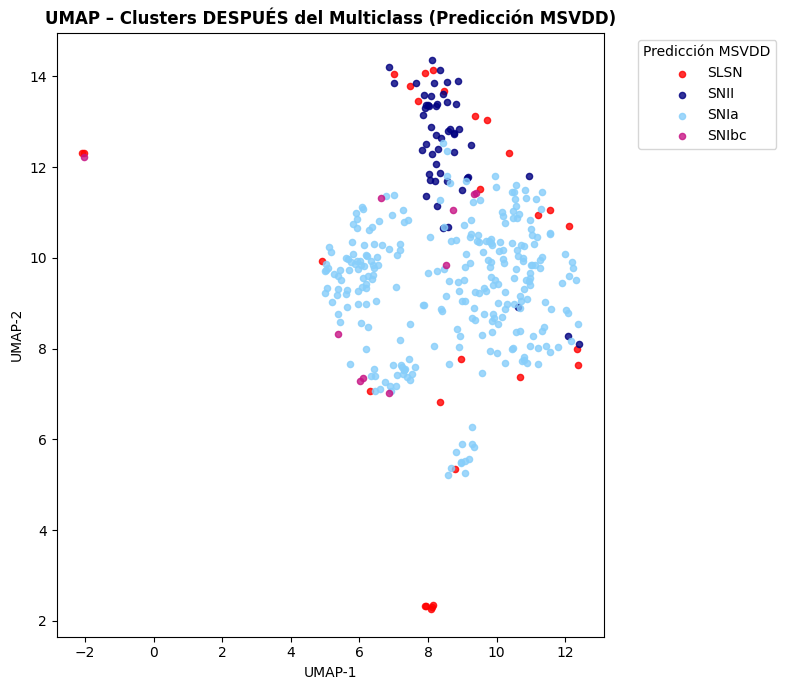

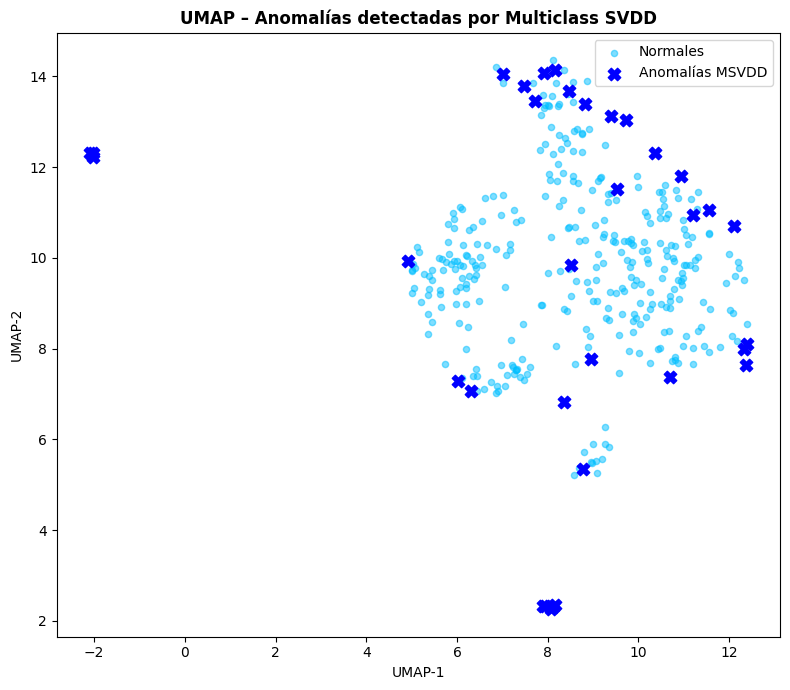

In [182]:
print("\n" + "="*70)
print("VISUALIZACIÓN DE ANOMALÍAS")
print("="*70)

# Clusters por predicción MSVDD
plot_umap_by_pred(Z_test_2D_umap, Z_pred_msvdd, class_names_sn, custom_colors=custom_colors)

# Anomalías en UMAP
plot_umap_anomalies(Z_test_2D_umap, anomaly_score)

In [183]:
from sklearn.model_selection import train_test_split

# Recuperar OIDs del test set
oids = df_sn['oid'].values
_, oids_test, _, _ = train_test_split(
    oids,
    y_int,
    test_size=0.20,
    random_state=42,
    stratify=y_int
)

df_anomalies_results = pd.DataFrame({
    'oid': oids_test,
    'Clase_Verdadera': le.inverse_transform(y_test_int),
    'Clase_Predicha_MSVDD': le.inverse_transform(Z_pred_msvdd),
    'Max_Score': anomaly_score
})

# Filtrar anomalías
anomaly_mask = (df_anomalies_results['Max_Score'] < 0.0)
df_anomalies = df_anomalies_results[anomaly_mask].copy()
anomaly_oids = df_anomalies['oid'].values

print("\n" + "="*70)
print(f"ANOMALÍAS DETECTADAS por MSVDD: {len(anomaly_oids)} objetos")
print("="*70)

if len(anomaly_oids) > 0:
    print("\nTop 10 anomalías más extremas (score más negativo):")
    print(df_anomalies[['oid', 'Clase_Verdadera', 'Clase_Predicha_MSVDD', 'Max_Score']]
          .sort_values(by='Max_Score').head(10).to_string(index=False))

    # Exportar
    df_anomalies[['oid', 'Clase_Verdadera', 'Clase_Predicha_MSVDD', 'Max_Score']].to_csv(
        'msvdd_anomalies_oids.csv', index=False
    )
    print("\n✓ Anomalías exportadas a 'msvdd_anomalies_oids.csv'")
else:
    print("No se detectaron anomalías con el threshold actual.")



ANOMALÍAS DETECTADAS por MSVDD: 34 objetos

Top 10 anomalías más extremas (score más negativo):
         oid Clase_Verdadera Clase_Predicha_MSVDD  Max_Score
ZTF19abvjdfc            SNIa                 SLSN  -0.624462
ZTF18acbwaxk            SNII                 SLSN  -0.624454
ZTF19aaeoqkk            SNIa                 SLSN  -0.619941
ZTF18absoomk            SNIa                 SLSN  -0.575080
ZTF18acptgzz            SNIa                 SLSN  -0.448180
ZTF19abnagzk            SNIa                 SLSN  -0.420973
ZTF18abwwuug            SNIa                 SLSN  -0.414454
ZTF18abmxfrc            SNIa                 SLSN  -0.392762
ZTF19abakdjd            SNIa                 SLSN  -0.383978
ZTF19acxphhl            SNIa                 SLSN  -0.383401

✓ Anomalías exportadas a 'msvdd_anomalies_oids.csv'


In [184]:
def plot_anomaly_lightcurve(oid_target, detections_df, cross_df):
    """
    Grafica la curva de luz para un objeto específico.
    """
    cross_subset = cross_df[['oid', 'classALeRCE']].drop_duplicates(subset='oid')
    df_merged = detections_df.merge(cross_subset, left_on='objectId', right_on='oid', how='left')
    obj = df_merged[df_merged['objectId'] == oid_target]

    if obj.empty:
        print(f"No se encontró el objeto {oid_target}")
        return

    clase = obj['classALeRCE'].iloc[0] if not obj['classALeRCE'].empty else "Desconocida"
    mjd_min = obj['mjd'].min()

    plt.figure(figsize=(9, 6))

    for fid, color, nombre in zip([1, 2], ['g', 'r'], ['Filtro g', 'Filtro r']):
        subset = obj[obj['fid'] == fid]
        if not subset.empty:
            plt.errorbar(
                subset['mjd'] - mjd_min,
                subset['magpsf'],
                yerr=subset['sigmapsf'],
                fmt='o',
                color=color,
                label=nombre,
                alpha=0.8,
                capsize=3
            )

    plt.gca().invert_yaxis()
    plt.title(f"Curva de luz de {oid_target} (Clase: {clase})", fontweight='bold')
    plt.xlabel(f"Tiempo relativo (MJD - {mjd_min:.2f} días)")
    plt.ylabel("Magnitud aparente (magpsf)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
# if len(anomaly_oids) > 0:
#     oid_anomalia = anomaly_oids[0]
#     plot_anomaly_lightcurve(oid_anomalia, detecciones, cross)



GRAFICANDO LAS 5 ANOMALÍAS MÁS EXTREMAS

OID: ZTF19abvjdfc
Clase verdadera: SNIa | Predicha: SLSN
Anomaly Score: -0.6245


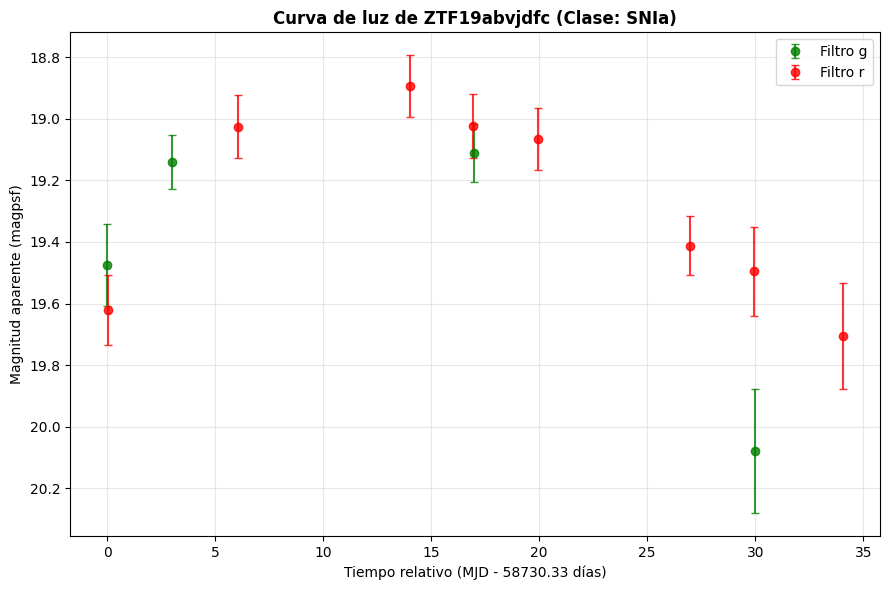


OID: ZTF18acbwaxk
Clase verdadera: SNII | Predicha: SLSN
Anomaly Score: -0.6245


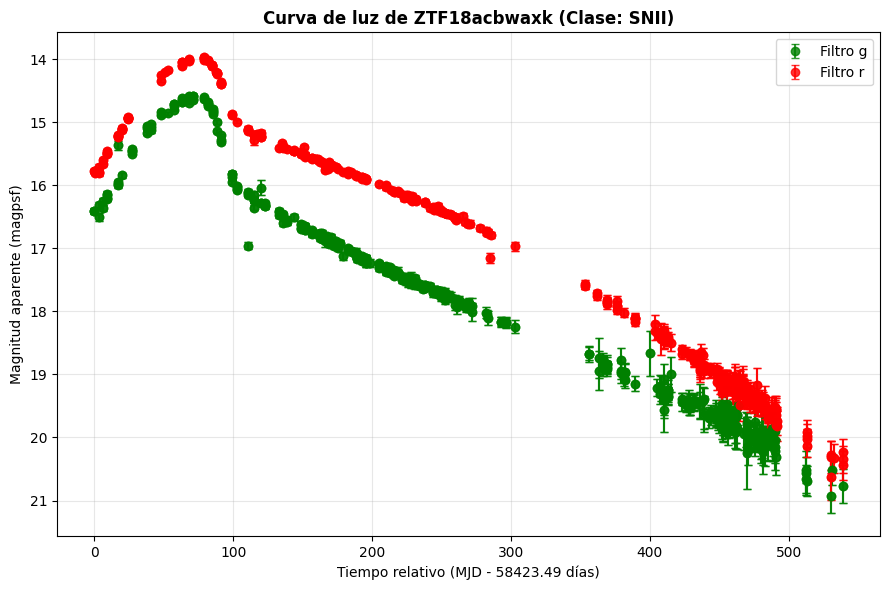


OID: ZTF19aaeoqkk
Clase verdadera: SNIa | Predicha: SLSN
Anomaly Score: -0.6199


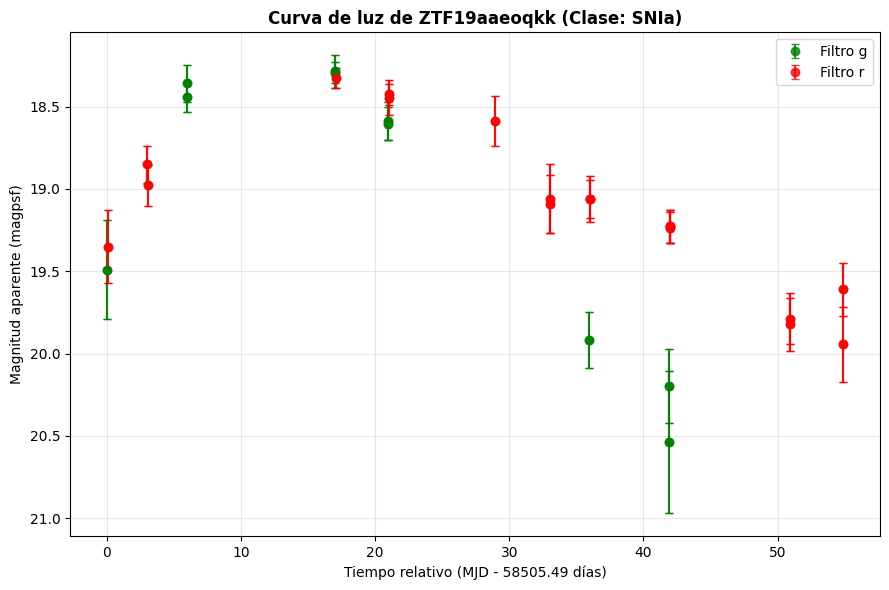


OID: ZTF18absoomk
Clase verdadera: SNIa | Predicha: SLSN
Anomaly Score: -0.5751


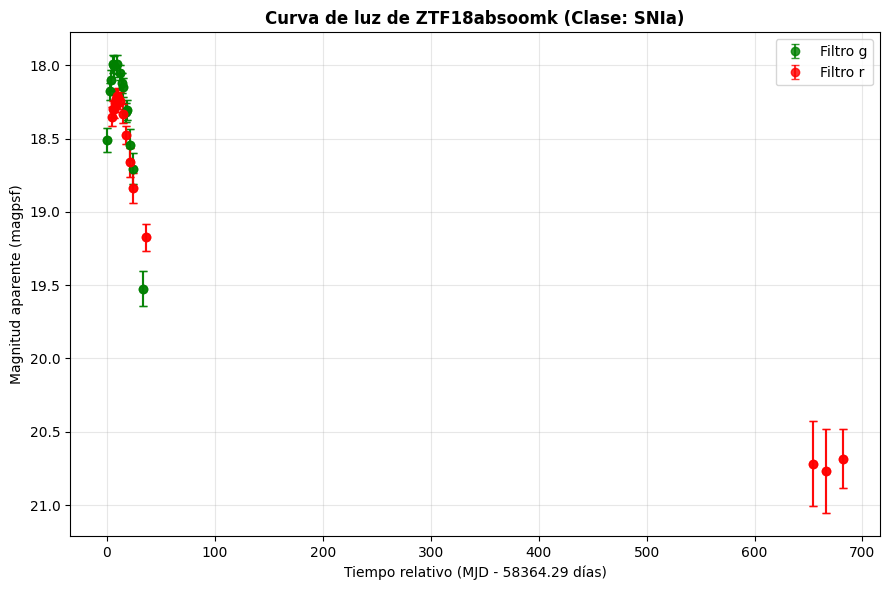


OID: ZTF18acptgzz
Clase verdadera: SNIa | Predicha: SLSN
Anomaly Score: -0.4482


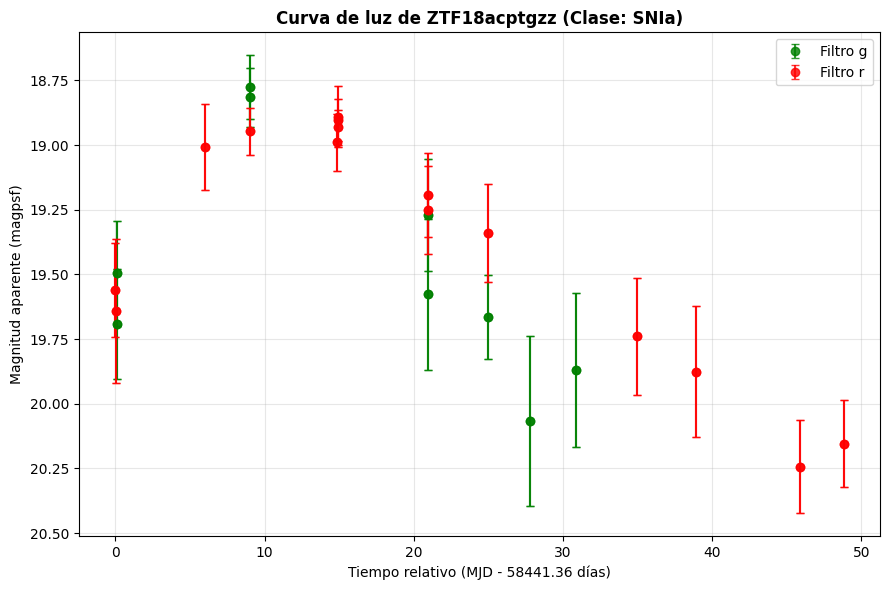

In [185]:
print("\n" + "="*70)
print("GRAFICANDO LAS 5 ANOMALÍAS MÁS EXTREMAS")
print("="*70)

if len(anomaly_oids) > 0:
    # Obtener las 5 más anómalas (score más negativo)
    top_5_anomalias = df_anomalies.nsmallest(5, 'Max_Score')

    for idx, row in top_5_anomalias.iterrows():
        oid = row['oid']
        score = row['Max_Score']
        clase_real = row['Clase_Verdadera']
        clase_pred = row['Clase_Predicha_MSVDD']

        print(f"\n{'='*70}")
        print(f"OID: {oid}")
        print(f"Clase verdadera: {clase_real} | Predicha: {clase_pred}")
        print(f"Anomaly Score: {score:.4f}")
        print(f"{'='*70}")

        plot_anomaly_lightcurve(oid, detecciones, cross)

In [186]:
def comparar_anomalia_con_normal(oid_anomalia, detections_df, cross_df, y_test_int, oids_test):
    """
    Compara la curva de luz de una anomalía con un objeto normal de su misma clase.
    """
    # Obtener clase de la anomalía
    anomalia_info = df_anomalies[df_anomalies['oid'] == oid_anomalia]
    if anomalia_info.empty:
        print(f" {oid_anomalia} no es una anomalía detectada")
        return

    clase_verdadera = anomalia_info['Clase_Verdadera'].iloc[0]

    # Buscar un objeto NORMAL de la misma clase
    clase_idx = le.transform([clase_verdadera])[0]

    # Objetos normales: bien clasificados y con score >= 0
    normales_misma_clase = df_anomalies_results[
        (df_anomalies_results['Clase_Verdadera'] == clase_verdadera) &
        (df_anomalies_results['Clase_Predicha_MSVDD'] == clase_verdadera) &
        (df_anomalies_results['Max_Score'] >= 0)
    ]

    if normales_misma_clase.empty:
        print(f"No hay objetos normales de clase {clase_verdadera}")
        return

    # Elegir uno al azar
    oid_normal = normales_misma_clase.sample(1)['oid'].iloc[0]

    print(f"\n{'='*70}")
    print(f"COMPARACIÓN: Anomalía vs Normal (Clase: {clase_verdadera})")
    print(f"{'='*70}")

    # Graficar ambos
    print(f"\n ANOMALÍA: {oid_anomalia}")
    plot_anomaly_lightcurve(oid_anomalia, detections_df, cross_df)

    print(f"\n NORMAL: {oid_normal}")
    plot_anomaly_lightcurve(oid_normal, detections_df, cross_df)

# Ejemplo de uso:
# if len(anomaly_oids) > 0:
#     comparar_anomalia_con_normal(anomaly_oids[0], detecciones, cross, y_test_int, oids_test)



COMPARACIÓN: Anomalía vs Normal (Clase: SNIa)

 ANOMALÍA: ZTF18absoomk


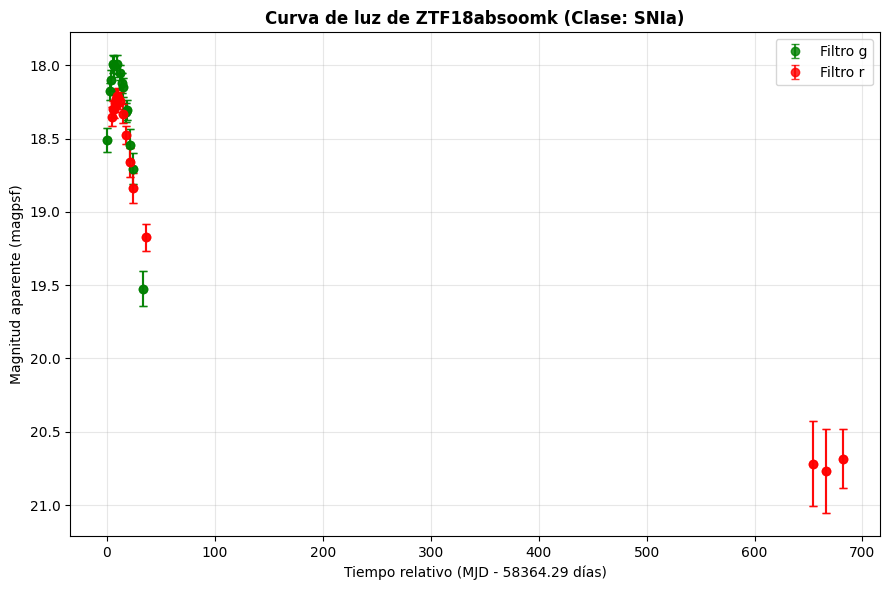


 NORMAL: ZTF20abedygm


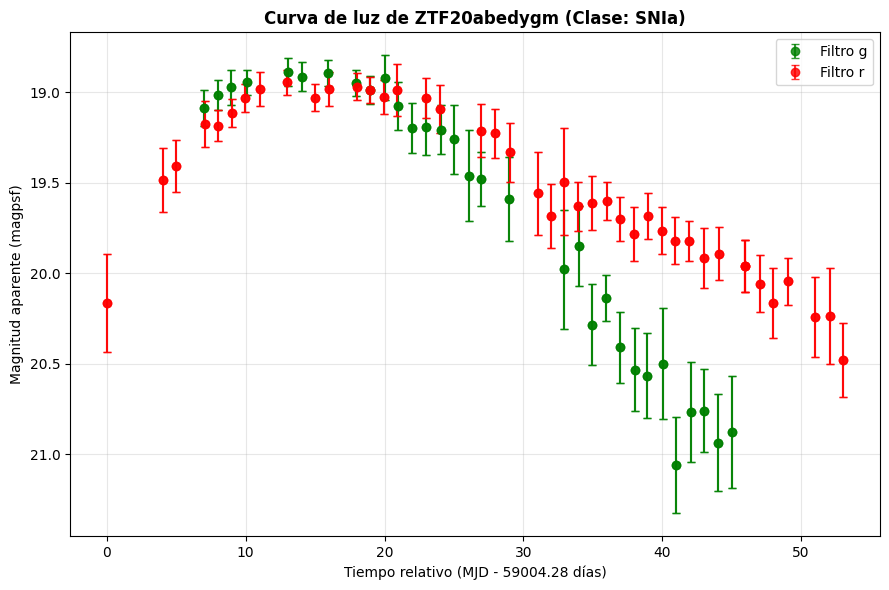

In [202]:
 if len(anomaly_oids) > 0:
     comparar_anomalia_con_normal('ZTF18absoomk', detecciones, cross, y_test_int, oids_test)


COMPARACIÓN: Anomalía vs Normal (Clase: SNII)

 ANOMALÍA: ZTF18acbwaxk


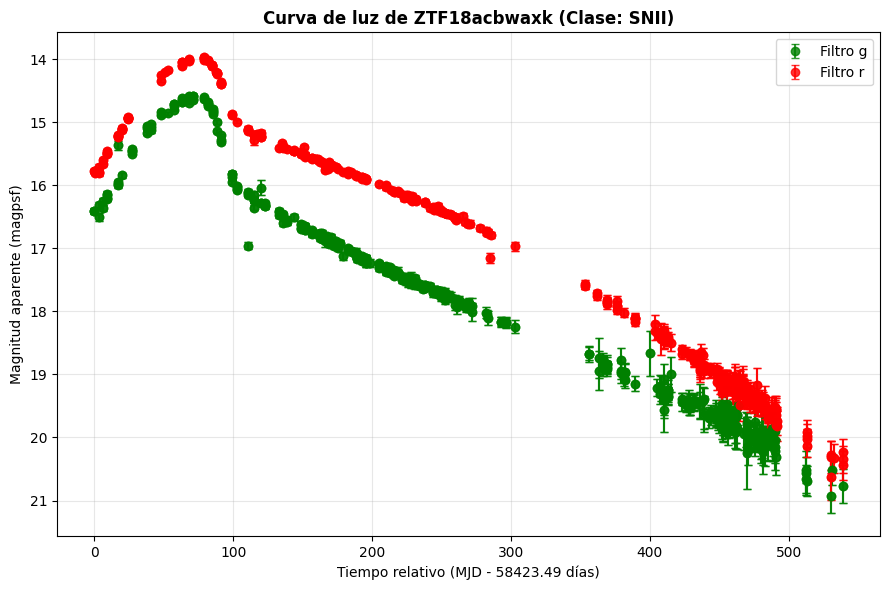


 NORMAL: ZTF19abpvbzf


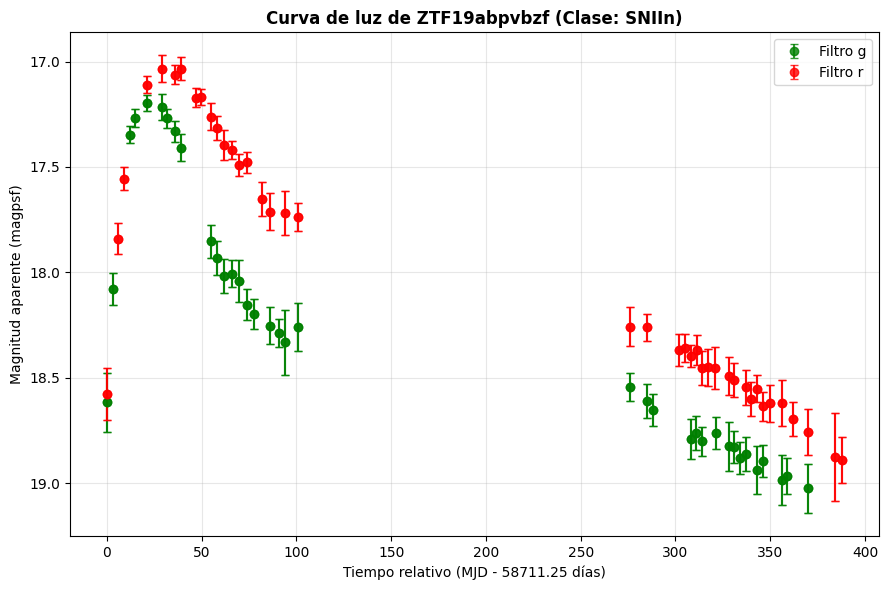

In [204]:
 if len(anomaly_oids) > 0:
     comparar_anomalia_con_normal('ZTF18acbwaxk', detecciones, cross, y_test_int, oids_test)